Generated Circles: [Circle(0.0, 0.0, 0.07880722471897195), Circle(0.0, 0.0, 2.9807524500207636), Circle(0.0, 0.0, 1.5609517465898053), Circle(0.0, 0.0, 3.4730833823220464), Circle(0.0, 0.0, 3.2523515122538105), Circle(0.0, 0.0, 3.668549048734826), Circle(0.0, 0.0, 4.135766082899936), Circle(0.0, 0.0, 1.628495641757401), Circle(0.0, 0.0, 0.030902246210785522), Circle(0.0, 0.0, 2.4914559059922556), Circle(0.0, 0.0, 1.4959262829634175), Circle(0.0, 0.0, 0.726397276744713), Circle(0.0, 0.0, 3.250090272733436), Circle(0.0, 0.0, 3.6318924278916915), Circle(0.0, 0.0, 4.877101657716504), Circle(0.0, 0.0, 0.0020246736948559274), Circle(0.0, 0.0, 4.913489928689603), Circle(0.0, 0.0, 2.448791362910683), Circle(0.0, 0.0, 1.7350102450399119), Circle(0.0, 0.0, 3.1301027296687844), Circle(0.0, 0.0, 3.2510487957182095), Circle(0.0, 0.0, 0.01748433816561923), Circle(0.0, 0.0, 2.131621300004901), Circle(0.0, 0.0, 2.8231398412197266), Circle(0.0, 0.0, 3.473605629813612), Circle(0.0, 0.0, 1.18004882014981

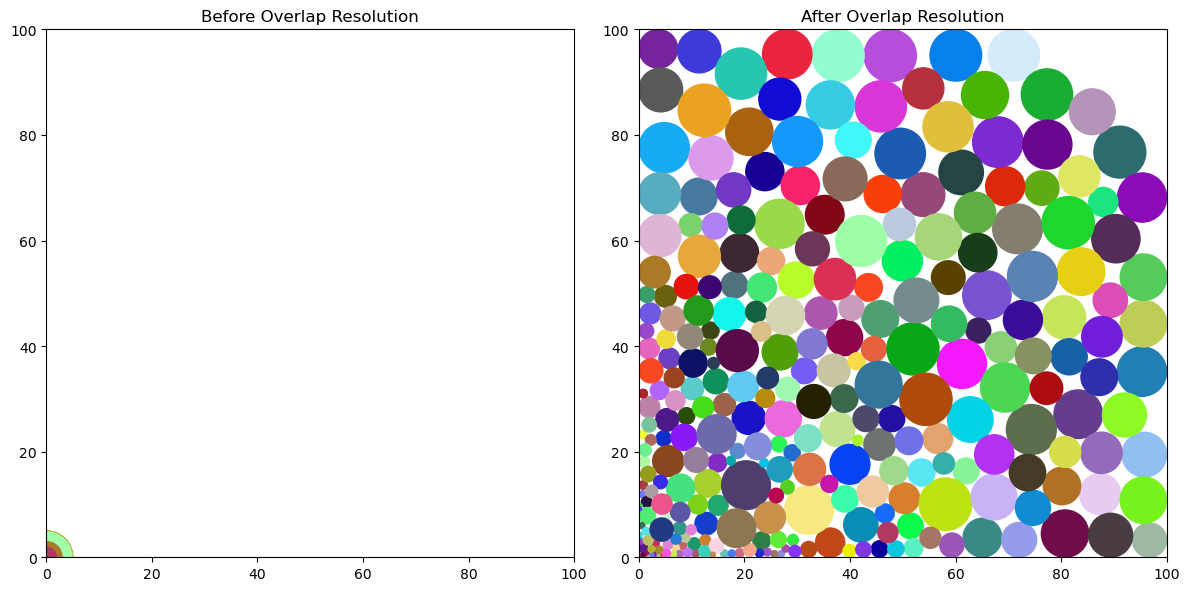

In [74]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math


class Rectangle:
    def __init__(self, x1, y1, x2, y2):
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2
    
    def intersects(self, other):
        return not (other.x2 < self.x1 or
                    other.x1 > self.x2 or
                    other.y2 < self.y1 or
                    other.y1 > self.y2)


class Circle:
    def __init__(self, x, y, radius):
        self.x = x
        self.y = y
        self.radius = radius

    def __repr__(self):
        return f"Circle({self.x}, {self.y}, {self.radius})"
    
    def intersects(self, other):
        """Check if this circle intersects with another circle."""
        distance = ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5
        return distance < (self.radius + other.radius)

    def bounding_box(self):
        """Return the bounding box of the circle."""
        return Rectangle(self.x - self.radius, self.y - self.radius, self.x + self.radius, self.y + self.radius)

class Quadtree:
    def __init__(self, x, y, width, height, level=0, max_levels=4, max_objects=4):
        # Define boundaries
        self.x = x
        self.y = y
        self.width = width
        self.height = height

        # Current depth level and limits
        self.level = level
        self.max_levels = max_levels
        self.max_objects = max_objects

        # Children trees (sub-quadrants)
        self.nw = None
        self.ne = None
        self.sw = None
        self.se = None

        # Objects in this quad
        self.objects = []

    def clear(self):
        """Clear out the quadtree of all objects."""
        self.objects = []
        if self.nw:
            self.nw.clear()
            self.ne.clear()
            self.sw.clear()
            self.se.clear()
        self.nw = None
        self.ne = None
        self.sw = None
        self.se = None

    def split(self):
        """Split the node into 4 child nodes."""
        x, y, w, h = self.x, self.y, self.width, self.height
        half_w, half_h = w / 2, h / 2
        next_level = self.level + 1

        self.nw = Quadtree(x, y, half_w, half_h, next_level)
        self.ne = Quadtree(x + half_w, y, half_w, half_h, next_level)
        self.sw = Quadtree(x, y + half_h, half_w, half_h, next_level)
        self.se = Quadtree(x + half_w, y + half_h, half_w, half_h, next_level)

    def get_indices(self, circle):
        """Determine which quadrants a circle intersects with."""
        x, y, w, h = self.x, self.y, self.width, self.height
        vertical_midpoint = x + w / 2
        horizontal_midpoint = y + h / 2

        indices = []

        top_quadrant = circle.y - circle.radius < horizontal_midpoint
        bottom_quadrant = circle.y + circle.radius >= horizontal_midpoint
        left_quadrant = circle.x - circle.radius < vertical_midpoint
        right_quadrant = circle.x + circle.radius >= vertical_midpoint

        if top_quadrant and left_quadrant:
            indices.append(0)  # NW
        if top_quadrant and right_quadrant:
            indices.append(1)  # NE
        if bottom_quadrant and left_quadrant:
            indices.append(2)  # SW
        if bottom_quadrant and right_quadrant:
            indices.append(3)  # SE
        
        return indices

    def insert(self, circle):
        # If the current quadtree has child quadtrees
        if self.nw is not None:
            indices = self.get_indices(circle)

            # If the circle spans multiple child quadtrees, store it in the current quadtree
            if len(indices) > 1:
                self.objects.append(circle)
            else:
                for index in indices:
                    [self.nw, self.ne, self.sw, self.se][index].insert(circle)
            return

        # If the quadtree doesn't have child quadtrees, store the circle in the current quadtree
        self.objects.append(circle)

        # If the number of objects exceeds the limit and we haven't reached the maximum depth, split and re-insert
        if len(self.objects) > self.max_objects and self.level < self.max_levels:
            if self.nw is None:
                self.split()
            i = 0
            while i < len(self.objects):
                current_circle = self.objects[i]
                indices = self.get_indices(current_circle)
                for index in indices:
                    [self.nw, self.ne, self.sw, self.se][index].insert(current_circle)
                    self.objects.pop(i)
                    break
                else:
                    i += 1



    def retrieve(self, return_objects, obj):
        indices = self.get_indices(obj)
        for index in indices:
            if self.nw:
                [self.nw, self.ne, self.sw, self.se][index].retrieve(return_objects, obj)
        return_objects.extend(self.objects)
        
    def query(self, circle):
        """Return items in the quadtree that might intersect with the given bounding box."""
        results = []
        if not circle.bounding_box().intersects(Rectangle(self.x, self.y, self.x+self.width, self.y+self.height)):
            return results

        for item in self.objects:
            if circle.intersects(item):
                results.append(item)

        if self.nw is not None:
            results.extend(self.nw.query(circle))
            results.extend(self.ne.query(circle))
            results.extend(self.sw.query(circle))
            results.extend(self.se.query(circle))

        return results



def generate_random_circles(num_circles, max_width, max_height, max_radius):
    circles = []
    for _ in range(num_circles):
        x = random.uniform(0, 0) #random.uniform(0, max_width)
        y = random.uniform(0, 0) #random.uniform(0, max_height)
        radius = random.uniform(0, max_radius)
        circles.append(Circle(x, y, radius))
    return circles

#def plot_circles(ax, circles, color='blue'):
#    for circle in circles:
#        circ_patch = patches.Circle((circle.x, circle.y), circle.radius, fc=color)
#        ax.add_patch(circ_patch)


def plot_circles(ax, circles, colors=None):
    for idx, circle in enumerate(circles):
        color = colors[idx] if colors else np.random.rand(3,)
        circle_plot = plt.Circle((circle.x, circle.y), circle.radius, color=color)
        ax.add_artist(circle_plot)
 
    
    
    
def overlap_distance(circle1, circle2):
    """Compute the overlap distance between two circles."""
    distance = ((circle1.x - circle2.x)**2 + (circle1.y - circle2.y)**2)**0.5
    overlap = circle1.radius + circle2.radius - distance
    return max(0, overlap)    
    
    
def resolve_overlap(circle1, circle2):
    """Resolve overlap between two circles by applying forces."""
    distance = ((circle1.x - circle2.x)**2 + (circle1.y - circle2.y)**2)**0.5
    if distance == 0:  # Randomly adjust for circles with the same center
        angle = 2 * np.pi * random.random()
        dx = np.cos(angle)
        dy = np.sin(angle)
    else:
        dx = (circle2.x - circle1.x) / distance
        dy = (circle2.y - circle1.y) / distance

    overlap = overlap_distance(circle1, circle2)
    minimal_move_distance = overlap / 2 + 0.01

    # Introduce a force model: F = k * overlap (like a spring force, where k is a spring constant)
    # Here, we'll assume k=1 for simplicity, but you can adjust it as needed.
    force_magnitude = overlap + random.uniform(-0.1 * overlap, 0.1 * overlap)  # Add some noise to the force

    # Perturb the direction with some randomness
    angle_perturbation = random.uniform(-np.pi / 6, np.pi / 6)  # Perturb up to 30 degrees
    dx = np.cos(np.arctan2(dy, dx) + angle_perturbation)
    dy = np.sin(np.arctan2(dy, dx) + angle_perturbation)

    move_distance = max(minimal_move_distance, force_magnitude)
    
    circle1.x -= dx * move_distance
    circle1.y -= dy * move_distance
    circle2.x += dx * move_distance
    circle2.y += dy * move_distance
    
    
def resolve_all_overlaps(circles, max_iterations=1000, WIDTH=100, HEIGHT=100):
    for _ in range(max_iterations):
        any_overlap = False
        for i, circle_a in enumerate(circles):
            for j, circle_b in enumerate(circles):
                if i != j and circle_a.intersects(circle_b):
                    any_overlap = True
                    overlap_distance = circle_a.radius + circle_b.radius - distance(circle_a, circle_b)
                    move_distance = overlap_distance / 2 + 0.01

                    # Calculate angle of repulsion
                    angle = math.atan2(circle_a.y - circle_b.y, circle_a.x - circle_b.x)

                    # Add noise to the angle
                    noise = random.uniform(-0.2, 0.2)  # Adjust this value for more or less noise
                    angle += noise

                    # Calculate the forces for the two circles
                    force_a = move_distance + random.uniform(0, 0.2 * move_distance)
                    force_b = move_distance + random.uniform(0, 0.2 * move_distance)

                    # Update circle positions based on the repulsion force
                    circle_a.x += math.cos(angle) * force_a
                    circle_a.y += math.sin(angle) * force_a

                    circle_b.x -= math.cos(angle) * force_b
                    circle_b.y -= math.sin(angle) * force_b

                    # Ensure circle centers stay inside boundaries
                    circle_a.x = max(circle_a.radius, min(WIDTH - circle_a.radius, circle_a.x))
                    circle_a.y = max(circle_a.radius, min(HEIGHT - circle_a.radius, circle_a.y))

                    circle_b.x = max(circle_b.radius, min(WIDTH - circle_b.radius, circle_b.x))
                    circle_b.y = max(circle_b.radius, min(HEIGHT - circle_b.radius, circle_b.y))

        if not any_overlap:
            break

    
    
def visualize_quadtree(quadtree, circles, WIDTH, HEIGHT):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Generate a consistent color list for the circles
    colors = [np.random.rand(3,) for _ in circles]

    # Original plot before resolving overlaps
    ax = axes[0]
    ax.set_title("Before Overlap Resolution")
    ax.set_aspect('equal', 'box')
    ax.set_xlim(0, WIDTH)
    ax.set_ylim(0, HEIGHT)
    plot_circles(ax, circles, colors=colors)

    # Copy circles list to have a new list for resolved circles
    circles_resolved = [Circle(c.x, c.y, c.radius) for c in circles]
    resolve_all_overlaps(circles_resolved)

    # Plot after resolving overlaps
    ax = axes[1]
    ax.set_title("After Overlap Resolution")
    ax.set_aspect('equal', 'box')
    ax.set_xlim(0, WIDTH)
    ax.set_ylim(0, HEIGHT)
    plot_circles(ax, circles_resolved, colors=colors)

    plt.tight_layout()
    plt.show()
    
def distance(circle_a, circle_b):
    dx = circle_a.x - circle_b.x
    dy = circle_a.y - circle_b.y
    return (dx**2 + dy**2)**0.5

    
def visualize_quadtree_old(quadtree, circles, WIDTH, HEIGHT):
    fig, ax = plt.subplots()

    # Set the aspect of the plot to be equal, so circles aren't elliptical
    ax.set_aspect('equal', 'box')
    ax.set_xlim(0, WIDTH)
    ax.set_ylim(0, HEIGHT)

    # Plot all circles in blue
    plot_circles(ax, circles)

    # Pick a random circle to query and plot it in red
    circle_to_query = random.choice(circles)
    plot_circles(ax, [circle_to_query], color='red')

    # Query the neighbors
    neighbors = quadtree.query(circle_to_query)
    # Remove the query circle from the neighbors list to avoid plotting it again
    if circle_to_query in neighbors:
        neighbors.remove(circle_to_query)
    # Plot the neighbors in green
    plot_circles(ax, neighbors, color='green')

    plt.show()


    
def main():
    WIDTH, HEIGHT = 100, 100
    NUM_CIRCLES = 295
    MAX_RADIUS = 5

    quadtree = Quadtree(0, 0, WIDTH, HEIGHT)
    circles = generate_random_circles(NUM_CIRCLES, WIDTH, HEIGHT, MAX_RADIUS)

    print(f"Generated Circles: {circles}\n")

    for circle in circles:
        quadtree.insert(circle)

    visualize_quadtree(quadtree, circles, WIDTH, HEIGHT)


if __name__ == "__main__":
    main()